In [60]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

In [61]:
class Runge_Kutta_Solver:

    def __init__(self, parameters):

        # Number of steps
        self.N = parameters['N']

        # Parameters
        self.Q = parameters['Q']
        self.R = parameters['R']
        self.S = parameters['S']
        self.A = parameters['A']
        self.B = parameters['B']
        self.C = parameters['C']
        self.D = parameters['D']
        self.G = parameters['G']
        self.L = parameters['L']

        # Compute the inverses Q_tilde, R_tilde, S_tilde
        self.QSSR = np.concatenate(
            (np.concatenate((self.Q, self.S.T), axis=1),
             np.concatenate((self.S, self.R), axis=1)),
            axis=0)
        self.QSSR_inv = np.linalg.inv(self.QSSR)
        self.Q_tilde = self.QSSR_inv[:2, :2]
        self.S_tilde = self.QSSR_inv[:2, 2:]
        self.R_tilde = self.QSSR_inv[2:, 2:]

        # Dictionary to store the RHS of ODEs
        self.ode_functions = {
                    'P': self.dPdt,
                    'P_tilde': self.P_tilde_RHS,
                    'M': self.dMdt,
                    'M_tilde': self.M_tilde_RHS,
                    'N': self.dNdt,
                    'N_tilde': self.N_tilde_RHS
        }

        # Dictionary to store the terminal conditions
        self.ode_terminal_conditions = {
            'P': -self.G,
            'P_tilde': -np.linalg.inv(self.G),
            'M': -self.L,
            'M_tilde': -np.linalg.inv(self.G) @ self.L,
            'N': 0,
            'N_tilde': - 0.5 * self.L.T @ np.linalg.inv(self.G) @ self.L
        }

        # Store the solutions to the ODEs
        # Primal ODEs
        self.time = self.solve_ODE("P")[0]
        self.P_solution = self.solve_ODE("P")[1]
        self.P_solution_interp = interp1d(self.solve_ODE("P")[0],
                                          self.P_solution,
                                          axis=0,
                                          fill_value='extrapolate')
        self.M_solution = self.solve_ODE("M")[1]
        self.M_solution_interp = interp1d(self.solve_ODE("M")[0],
                                          self.M_solution,
                                          axis=0,
                                          fill_value='extrapolate')
        self.N_solution = self.solve_ODE("N")[1]

        # Dual ODEs
        self.P_tilde_solution = self.solve_ODE("P_tilde")[1]
        self.P_tilde_solution_interp = interp1d(self.solve_ODE("P_tilde")[0],
                                                self.P_tilde_solution,
                                                axis=0,
                                                fill_value='extrapolate')
        self.M_tilde_solution = self.solve_ODE("M_tilde")[1]
        self.M_tilde_solution_interp = interp1d(self.solve_ODE("M_tilde")[0],
                                                self.M_tilde_solution,
                                                axis=0,
                                                fill_value='extrapolate')
        self.N_tilde_solution = self.solve_ODE("N_tilde")[1]

    def dPdt(self, t, P):
        """
        Return the right-hand side of the ODE for P.
        """

        # Compute theta
        theta = (
            np.linalg.inv(self.D.T @ P @ self.D - self.R) @
            (- self.B.T @ P - self.D.T @ P @ self.C)
        )

        # Compute the RHS
        dPdt = (
            - 2 * self.A.T @ P - theta.T @ self.B.T @ P.T - P @ self.B @ theta
            - (self.C.T + theta.T @ self.D.T) @ P @ (self.C + self.D @ theta)
            + self.Q + theta.T @ self.R @ theta
        )

        return dPdt

    def dMdt(self, t, M):
        """
        Return the RHS of the ODE for M.
        """

        # Get solution for P
        P = self.P_solution_interp(t)

        # Compute k
        k = (
            - np.linalg.inv(self.D.T @ P @ self.D + self.R) @ self.B.T @ M
        )

        # Compute theta
        theta = (
            np.linalg.inv(self.D.T @ P @ self.D - self.R) @
            (- self.B.T @ P - self.D.T @ P @ self.C)
        )

        # Compute the RHS
        dMdt = (
            - self.A.T @ M - P @ self.B @ k - theta.T @ self.B.T @ M
            - (self.C.T + theta.T @ self.D.T) @ P @ self.D @ k
            + theta.T @ self.R @ k
        )

        return dMdt

    def dNdt(self, t, N):
        """
        Return the RHS of the ODE for N.
        """

        # Get solution for P
        P = self.P_solution_interp(t)

        # Get solution for M
        M = self.M_solution_interp(t)

        # Compute k
        k = (
            - np.linalg.inv(self.D.T @ P @ self.D + self.R) @ self.B.T @ M
        )

        # dN/dt = - k^T B^T M - 1/2 k^T D^T P D k + 1/2 k^T R k
        dNdt = (
            - k.T @ self.B.T @ M - 0.5 * k.T @ self.D.T @ P @ self.D @ k
            + 0.5 * k.T @ self.R @ k
        )

        return 0

    def P_tilde_RHS(self, t, P):
        """
        Return the RHS of the ODE for P_tilde.
        """

        # Compute theta
        theta = (
            np.linalg.inv(self.Q_tilde) @ P
        )

        # Compute theta_1
        theta_1 = (
            np.linalg.inv(P - self.D @ self.R_tilde @ self.D.T)
            @ (self.C @ P + self.D @ self.R_tilde @ self.B.T)
        )

        # Compute the RHS
        dPdt = (
            - 2 * theta.T @ P + 2 * self.A @ P
            + 2 * theta_1.T @ self.C @ P - 2 * theta_1.T @ P @ theta_1
            + theta.T @ self.Q_tilde @ theta + 2 * theta.T @ self.S_tilde.T
            @ (self.B.T + self.D.T @ theta_1) + (self.B + theta_1.T @ self.D)
            @ self.R_tilde @ (self.B.T + self.D.T @ theta_1)
        )

        return dPdt

    def M_tilde_RHS(self, t, M):
        """
        Return the RHS of the ODE for M_tilde.
        """

        # Get the solution for P
        P = self.P_tilde_solution_interp(t)

        # Compute theta
        theta = (
            np.linalg.inv(self.Q_tilde) @ P
        )

        # Compute theta_1
        theta_1 = (
            np.linalg.inv(P - self.D @ self.R_tilde @ self.D.T)
            @ (self.C @ P + self.D @ self.R_tilde @ self.B.T)
        )

        # Compute k
        k = (
            np.linalg.inv(self.Q_tilde) @ M
        )

        # Compute k_1
        k_1 = (
           np.linalg.inv(P - self.D @ self.R_tilde @ self.D.T) @ self.C @ M
        )

        # Compute the RHS
        dMdt = (
            - P @ k + P @ self.C.T @ k_1 - theta.T @ M + self.A @ M
            + theta_1.T @ self.C @ M
            - theta_1 @ P @ k_1 + theta.T @ self.Q_tilde @ k
            + (self.B + theta_1.T @ self.D) @ (self.R_tilde @ self.D.T @ k_1)
        )

        return dMdt

    def N_tilde_RHS(self, t, y):
        """
        Return the RHS of the ODE for N_tilde.
        """

        # Get solution for P
        P = self.P_tilde_solution_interp(t)

        # Get solution for M
        M = self.M_tilde_solution_interp(t)

        # Compute k
        k = (
            np.linalg.inv(self.Q_tilde) @ M
        )

        # Compute k_1
        k_1 = (
           np.linalg.inv(P - self.D @ self.R_tilde @ self.D.T) @ self.C @ M
        )

        # Compute RHS
        dNdt = (
            - k.T @ M + k_1.T @ self.C @ M - 0.5 * k_1.T @ P @ k_1
            + 0.5 * k.T @ self.Q_tilde @ k
            + k.T @ self.S_tilde.T @ self.D.T @ k_1
            + 0.5 * k_1.T @ self.D @ self.R_tilde @ self.D.T @ k_1
        )

        return dNdt

    def solve_ODE(self, ode_name):
        """
        Solve a given ODE using the Runge-Kutta numerical scheme.
        """
        if ode_name in ["M", "M_tilde"]:

            # Generate linearly spaced values from t_final to t_initial
            t = np.linspace(1.0, 0.0, self.N+1)

            # Calculate negative step size
            h = - 1.0 / self.N

            # Create numpy array y with the same shape as y_terminal
            y = np.zeros((self.N+1, 2, 1))

            # Set terminal conditions as the first element of y
            y[0, :] = self.ode_terminal_conditions[ode_name]

            # Define the ODE function
            ode_fun = self.ode_functions[ode_name]

            # Iterate through time steps
            for i in range(self.N):

                # Calculate intermediate values k1, k2, k3, and k4
                k1 = h * ode_fun(t[i], y[i, :])
                k2 = h * ode_fun(t[i] - h/2, y[i, :] + k1/2)
                k3 = h * ode_fun(t[i] - h/2, y[i, :] + k2/2)
                k4 = h * ode_fun(t[i] - h, y[i, :] + k3)

                # Update y at next time step
                y[i+1, :] = y[i, :] + (k1 + 2*k2 + 2*k3 + k4) / 6

            # Return flipped t and y arrays (ascending order of time)
            return np.flip(t), np.flip(y, axis=0)

        elif ode_name in ["N", "N_tilde"]:

            # Generate linearly spaced values from t_final to t_initial
            t = np.linspace(1.0, 0.0, self.N+1)

            # Calculate negative step size
            h = - 1.0 / self.N

            # Create numpy array y with the same shape as y_terminal
            y = np.zeros((self.N+1))

            # Set terminal conditions as the first element of y
            y[0] = self.ode_terminal_conditions[ode_name]

            # Define the ODE function
            ode_fun = self.ode_functions[ode_name]

            # Iterate through time steps
            for i in range(self.N):

                # Calculate intermediate values k1, k2, k3, and k4
                k1 = h * ode_fun(t[i], y[i])
                k2 = h * ode_fun(t[i] - h/2, y[i] + k1/2)
                k3 = h * ode_fun(t[i] - h/2, y[i] + k2/2)
                k4 = h * ode_fun(t[i] - h, y[i] + k3)

                # Update y at next time step
                y[i+1] = y[i] + (k1 + 2*k2 + 2*k3 + k4) / 6

            # Return flipped t and y arrays (ascending order of time)
            return np.flip(t), np.flip(y, axis=0)

        elif ode_name in ["P", "P_tilde"]:

            # Generate linearly spaced values from t_final to t_initial
            t = np.linspace(1.0, 0.0, self.N+1)

            # Calculate negative step size
            h = - 1.0 / self.N

            # Create numpy array y with the same shape as y_terminal
            y = np.zeros((self.N+1, 2, 2))

            # Set terminal conditions as the first element of y
            y[0, :, :] = self.ode_terminal_conditions[ode_name]

            # Define the ODE function
            ode_fun = self.ode_functions[ode_name]

            # Iterate through time steps
            for i in range(self.N):

                # Calculate intermediate values k1, k2, k3, and k4
                k1 = h * ode_fun(t[i], y[i, :, :])
                k2 = h * ode_fun(t[i] - h/2, y[i, :, :] + k1/2)
                k3 = h * ode_fun(t[i] - h/2, y[i, :, :] + k2/2)
                k4 = h * ode_fun(t[i] - h, y[i, :, :] + k3)

                # Update y at next time step
                y[i+1, :, :] = y[i, :, :] + (k1 + 2*k2 + 2*k3 + k4) / 6

            # Return flipped t and y arrays (ascending order of time)
            return np.flip(t), np.flip(y, axis=0)

    def compute_V_primal(self, X):

        # Compute X^T
        X_T = np.transpose(X, (0, 2, 1))

        # Compute V from primal problem
        V_primal = (
            0.5 * X_T @ self.P_solution @ X
            + X_T @ self.M_solution
            #+ np.reshape(self.N_solution, (self.N+1, 1, 1))
        )

        # Reshape array from (N+1, 1, 1) to (N+1, )
        return np.reshape(V_primal, (self.N+1,))

    def compute_V_dual(self, X):

        # Compute X^T
        X_T = np.transpose(X, (0, 2, 1))

        # Compute V from dual problem
        V_dual = (
            0.5 * X_T @ self.P_tilde_solution @ X
            + X_T @ self.M_tilde_solution
            #+ np.reshape(self.N_tilde_solution, (self.N+1, 1, 1))
        )

        # Reshape array from (N+1, 1, 1) to (N+1, )
        return np.reshape(V_dual, (self.N+1,))

    def compute_V_primal_from_dual(self, X):

        # Compute X^T and M_tilde^T
        X_T = np.transpose(X, (0, 2, 1))
        M_tilde_T = np.transpose(self.M_tilde_solution, (0, 2, 1))

        # Compute the inverse of P_tilde
        P_tilde_inv = np.array(
            [np.linalg.inv(P) for P in self.P_tilde_solution]
        )

        # Compute the upper bound
        V = (
            0.5 * X_T @ P_tilde_inv @ X
            - X_T @ P_tilde_inv @ self.M_tilde_solution
            #+ 0.5 * M_tilde_T @ P_tilde_inv @ self.M_tilde_solution
            #- np.reshape(self.N_tilde_solution, (self.N+1, 1, 1))
        )

        # Reshape array from (N+1, 1, 1) to (N+1, )
        return np.reshape(V, (self.N+1, ))

    def compute_V_dual_from_primal(self, X):

        # Compute X^T and M_tilde^T
        X_T = np.transpose(X, (0, 2, 1))
        M_T = np.transpose(self.M_solution, (0, 2, 1))

        # Compute the inverse of P_tilde
        P_inv = np.array(
            [np.linalg.inv(P) for P in self.P_solution]
        )

        # Compute the upper bound
        V = (
            0.5 * X_T @ P_inv @ X
            - X_T @ P_inv @ self.M_solution
            #+ 0.5 * M_T @ P_inv @ self.M_solution
            #- np.reshape(self.N_solution, (self.N+1, 1, 1))
        )

        # Reshape array from (N+1, 1, 1) to (N+1, )
        return np.reshape(V, (self.N+1, ))

    def plot_ODE_solution(self, ode_name):
        """
        Plot the solution to a given ODE.
        """

        # Compute the number of elements
        if ode_name in ["P", "P_tilde"]:
            size = 4
        elif ode_name in ["M", "M_tilde"]:
            size = 2
        elif ode_name in ["N", "N_tilde"]:
            size = 1

        # Compute t and y  using solve_ODE
        t, y = self.solve_ODE(ode_name)

        # Plot y vs t for each of the 4 elements in y
        plt.figure(figsize=(15, 5))
        plt.plot(t, np.reshape(y, (self.N+1, size)), color='C0')
        plt.title(f"Solution of the ODE for {ode_name}")
        plt.xlabel("Time")
        plt.ylabel(ode_name)
        plt.grid()
        plt.show()


In [78]:
parameters_RK = {
    "Q": np.array([[0.1, 0.2], [0.2, 0.1]]),
    'R': np.array([[0.1, 0.2], [0.2, 0.1]]),
    'S': np.array([[0.0, 0.0], [0.0, 0.0]]),
    'A': np.array([[0.0, 0.1], [0.1, 0.0]]),
    'B': np.array([[0.3, 0.0], [0.0, 0.3]]),
    'C': np.array([[0.0, 0.2], [0.2, 0.0]]),
    'D': np.array([[0.2, 0.0], [0.0, 0.2]]),
    'G': np.array([[0.3, 0.1], [0.1, 0.3]]),
    'L': np.array([[0.1], [0.1]]),
    'N': 200,
}
ode_solver = Runge_Kutta_Solver(parameters_RK)

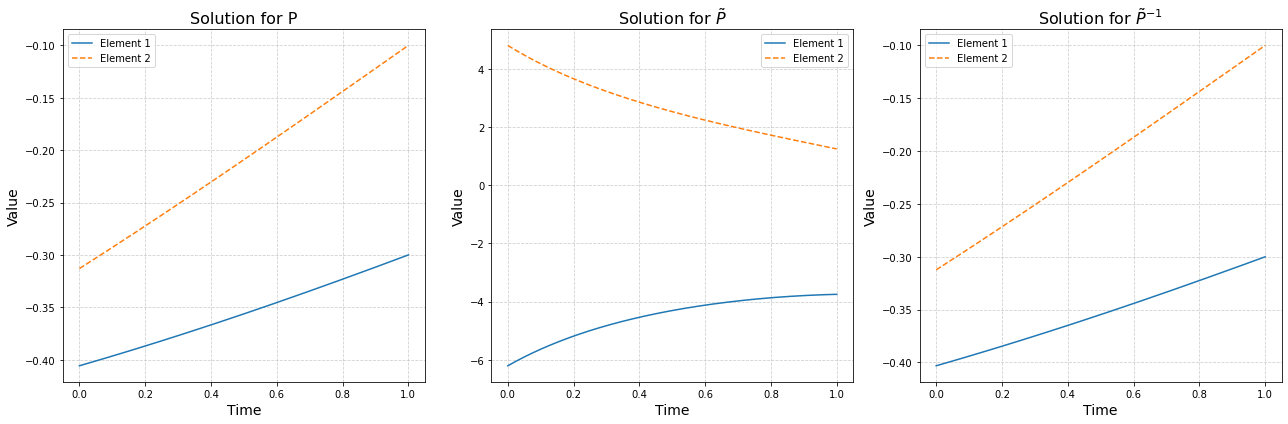

In [79]:
P_tilde_inv = np.zeros_like(ode_solver.P_tilde_solution)
for i in range(ode_solver.P_tilde_solution.shape[0]):
    P_tilde_inv[i] = np.linalg.inv(ode_solver.P_tilde_solution[i])

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

# customize the line style and width
line_styles = ['-', '--']
line_width = 1.5

# Plot P (first two elements)
P_values = np.reshape(ode_solver.P_solution, (ode_solver.N+1, 4))
for i in range(2):  # Only take the first two elements
    axs[0].plot(ode_solver.time, P_values[:, i], line_styles[i], linewidth=line_width, label=f'Element {i+1}')
axs[0].set_title('Solution for P', fontsize=16)
axs[0].set_xlabel('Time', fontsize=14)
axs[0].set_ylabel('Value', fontsize=14)
axs[0].grid(True, linestyle='--', alpha=0.6)
axs[0].legend()

# Plot P_tilde (first two elements)
P_tilde_values = np.reshape(ode_solver.P_tilde_solution, (ode_solver.N+1, 4))
for i in range(2):  # Only take the first two elements
    axs[1].plot(ode_solver.time, P_tilde_values[:, i], line_styles[i], linewidth=line_width, label=f'Element {i+1}')
axs[1].set_title(r'Solution for $\tilde{P}$', fontsize=16)
axs[1].set_xlabel('Time', fontsize=14)
axs[1].set_ylabel('Value', fontsize=14)
axs[1].grid(True, linestyle='--', alpha=0.6)
axs[1].legend()

# Plot P_tilde_inverse (first two elements)
P_tilde_inv_values = np.reshape(P_tilde_inv, (ode_solver.N+1, 4))
for i in range(2):  # Only take the first two elements
    axs[2].plot(ode_solver.time, P_tilde_inv_values[:, i], line_styles[i], linewidth=line_width, label=f'Element {i+1}')
axs[2].set_title(r'Solution for $\tilde{P}^{-1}$', fontsize=16)
axs[2].set_xlabel('Time', fontsize=14)
axs[2].set_ylabel('Value', fontsize=14)
axs[2].grid(True, linestyle='--', alpha=0.6)
axs[2].legend()

plt.tight_layout()
plt.show()


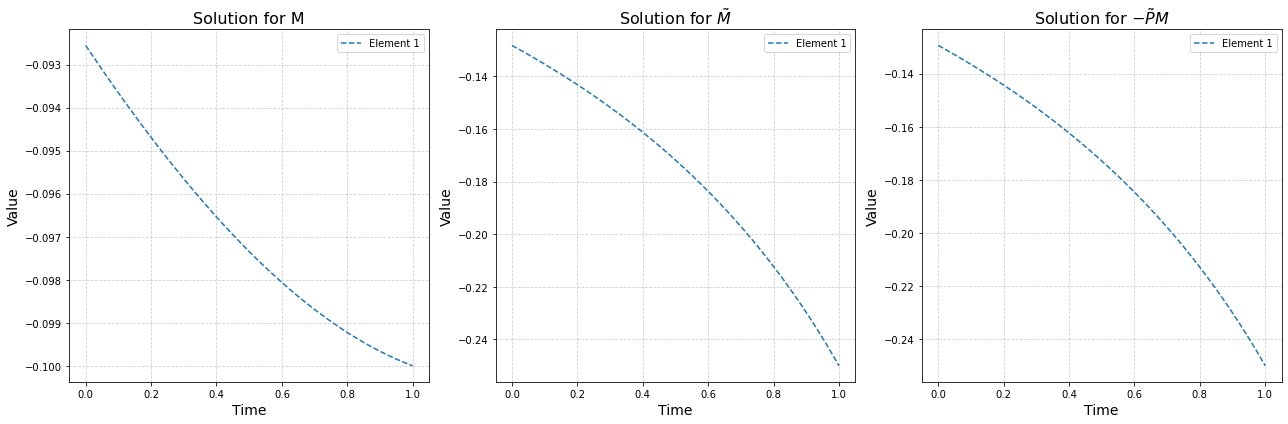

In [83]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

# customize the line style and width
line_styles = ['--']
line_width = 1.5

# Plot M (first two elements)
M_values = np.reshape(ode_solver.M_solution, (ode_solver.N+1, 2))
for i in range(1):  # Only take the first two elements
    axs[0].plot(ode_solver.time, M_values[:, i], line_styles[i], linewidth=line_width, label=f'Element {i+1}')
axs[0].set_title('Solution for M', fontsize=16)
axs[0].set_xlabel('Time', fontsize=14)
axs[0].set_ylabel('Value', fontsize=14)
axs[0].grid(True, linestyle='--', alpha=0.6)
axs[0].legend()

# Plot M_tilde (first two elements)
M_tilde_values = np.reshape(ode_solver.M_tilde_solution, (ode_solver.N+1, 2))
for i in range(1):  # Only take the first two elements
    axs[1].plot(ode_solver.time, M_tilde_values[:, i], line_styles[i], linewidth=line_width, label=f'Element {i+1}')
axs[1].set_title(r'Solution for $\tilde{M}$', fontsize=16)
axs[1].set_xlabel('Time', fontsize=14)
axs[1].set_ylabel('Value', fontsize=14)
axs[1].grid(True, linestyle='--', alpha=0.6)
axs[1].legend()

# Plot M_tilde_inverse (first two elements)
values = np.reshape(- P_tilde_inv @ ode_solver.M_tilde_solution, (ode_solver.N+1, 2))
values = np.reshape(- ode_solver.P_tilde_solution @ ode_solver.M_solution, (ode_solver.N+1, 2))
for i in range(1):  # Only take the first two elements
    axs[2].plot(ode_solver.time, values[:, i], line_styles[i], linewidth=line_width, label=f'Element {i+1}')
axs[2].set_title(r'Solution for $-\tilde{P} {M}$', fontsize=16)
axs[2].set_xlabel('Time', fontsize=14)
axs[2].set_ylabel('Value', fontsize=14)
axs[2].grid(True, linestyle='--', alpha=0.6)
axs[2].legend()

plt.tight_layout()
plt.show()